In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_curve, auc, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2.16.1


In [3]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# Veri Analizi
Veri seti incelenerek yaş, cinsiyet ve etnik köken sütunları analiz ediliyor. 
- Yaş verilerinin dağılımı görselleştiriliyor.
- Cinsiyet ve etnik köken dağılımı sayısal ve görsel olarak analiz ediliyor.

In [ ]:
df = pd.read_csv('C:/Users/yahya/OneDrive - Karabuk University/Masaüstü/Yeni klasör/age_gender.csv')

In [5]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


/tmp/ipykernel_23/1462740167.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age']);
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


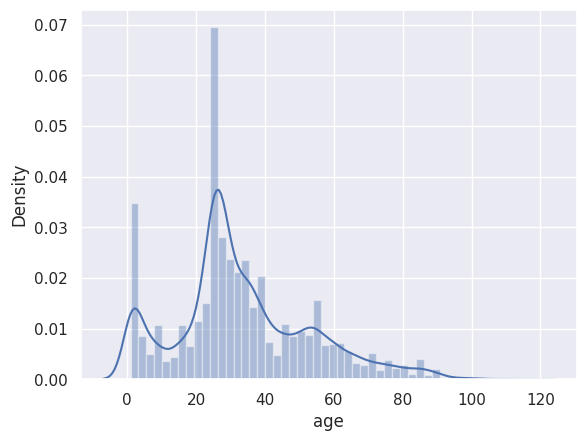

In [ ]:
sns.distplot(df['age'])

Unique values in 'gender': [0 1]
Value counts in 'gender':
gender
0    12391
1    11314
Name: count, dtype: int64


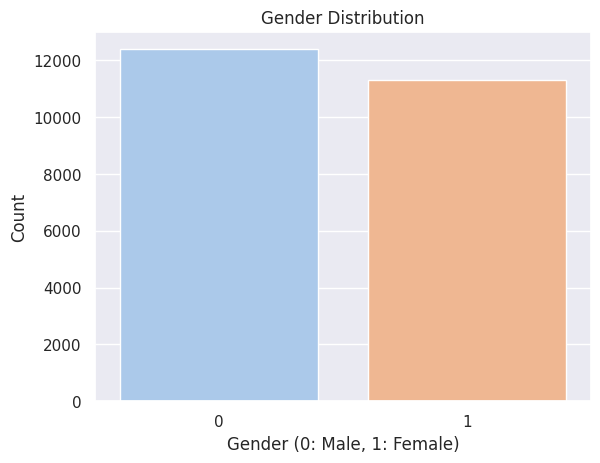

In [8]:
print("Unique values in 'gender':", df['gender'].unique())
print("Value counts in 'gender':")
print(df['gender'].value_counts())

sns.countplot(x='gender', data=df, palette='pastel')
plt.title("Gender Distribution")
plt.xlabel("Gender (0: Male, 1: Female)")
plt.ylabel("Count")
plt.show()

Unique values in 'ethnicity': [2 3 4 0 1]
Value counts in 'ethnicity':
ethnicity
0    10078
1     4526
3     3975
2     3434
4     1692
Name: count, dtype: int64


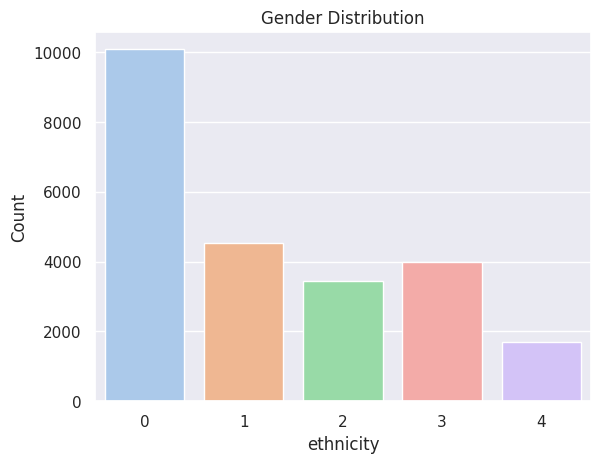

In [9]:
print("Unique values in 'ethnicity':", df['ethnicity'].unique())
print("Value counts in 'ethnicity':")
print(df['ethnicity'].value_counts())

sns.countplot(x='ethnicity', data=df, palette='pastel')
plt.title("Gender Distribution")
plt.xlabel("ethnicity")
plt.ylabel("Count")
plt.show()

# Piksel Verisinin İşlenmesi
- Görüntü verileri (pixels) numpy array'ine dönüştürülüyor ve `48x48` boyutunda yeniden şekillendiriliyor.
- Normalize ediliyor (`0-255` değerler arasından 0-1 aralığına dönüştürülüyor).
- Görüntü artırma işlemleri uygulanıyor (`ImageDataGenerator` ile).


In [10]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [11]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2)


X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

datagen.fit(X_reshaped)

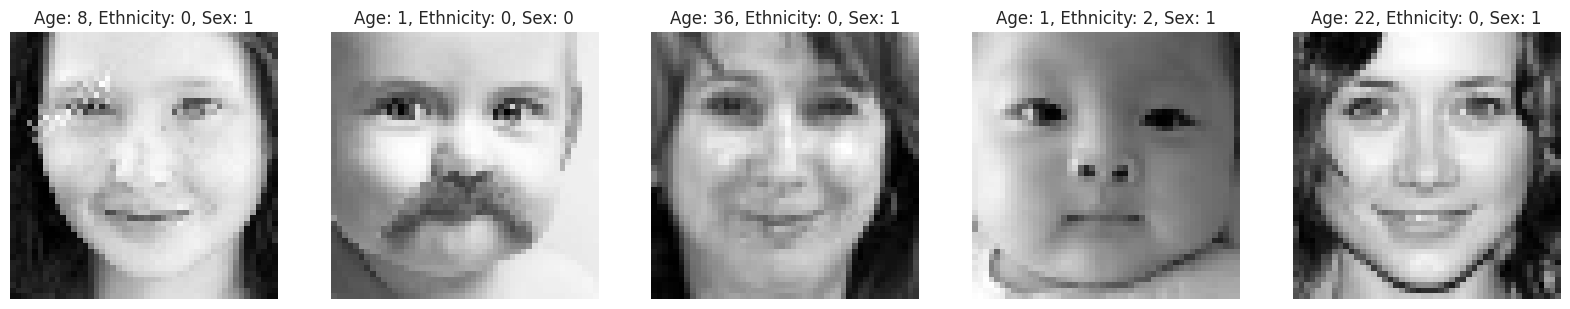

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face], cmap = 'gray')
    axes[i].axis('off')

In [13]:
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255 # Normalize etme

In [62]:
input_shape = X_reshaped.shape[1:]
n_epochs = 30
batch_size = 64

# Yaş Tahmini Modeli
- Model, 48x48 boyutunda gri ölçekli görüntüleri işleyerek yaş tahmini yapmak için oluşturulmuş bir regresyon modelidir.


In [63]:
y = df['age'].values

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [65]:
print('X Train Shape: ', X_train.shape)
print('y Train Shape: ', y_train.shape)
print('X Test Shape: ', X_test.shape)
print('y Test Shape: ', y_test.shape)

X Train Shape:  (18964, 48, 48, 1)
y Train Shape:  (18964,)
X Test Shape:  (4741, 48, 48, 1)
y Test Shape:  (4741,)


In [66]:
age_model = Sequential()

# Katman 1
# Görüntüdeki temel kenar ve köşe gibi düşük seviyeli özellikleri algılar.
# Aktivasyon Fonksiyonu: relu (Sıfırdan küçük değerleri sıfırlar, doğrusal olmayanlık ekler)
age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))  
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

# Katman 2
# Daha karmaşık özellikleri öğrenir.
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')) # Padding = same- Giriş ve çıkış boyutlarını korur.
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2))) # havuzlama ile boyut azaltılır
age_model.add(Dropout(0.3)) # Aşırı öğrenmeyi önler.
age_model.add(BatchNormalization()) #  Normalizasyon uygulanır.

# Katman 3
# Daha derin ve detaylı özellikler öğrenir.
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())


# Katman 4
# Modelin derinliğini artırarak daha soyut özellikler öğrenir.
age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

# Flatten Katmanı
# Görüntüden çıkarılan özellik haritasını düzleştirir (2D veriyi 1D vektöre dönüştürür).
age_model.add(Flatten())

# Fully Connected (Dense) Katman 1
# Özelliklerden öğrenme yapılır.
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))

# Fully Connected (Dense) Katman 2
# Nihai tahmini verir. Yani yaş tahmini
age_model.add(Dense(1)) 

age_model.compile(optimizer='adam', loss='mse', metrics = ['mae'])

# adam = Öğrenme oranını (learning rate) otomatik ayarlayan güçlü bir optimizasyon algoritması.
# mse = Sürekli değerler tahmini için uygun kayıp fonksiyonu
# mae = Eğitim ve değerlendirme sırasında kullanılan metrik.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
checkpoint = ModelCheckpoint('age_model.keras', monitor='val_loss', save_best_only=True, mode='min')
callbacks = [checkpoint]

In [68]:
history = age_model.fit(X_train, y_train, 
                        epochs=30,   
                        batch_size=batch_size, 
                        callbacks=callbacks, 
                        validation_data=(X_test, y_test)) 

Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 403.7924 - mae: 14.5667 - val_loss: 1331.7537 - val_mae: 32.5918
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 147.7525 - mae: 8.9040 - val_loss: 156.2616 - val_mae: 9.2874
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 126.8543 - mae: 8.2354 - val_loss: 156.5276 - val_mae: 9.5300
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 110.0708 - mae: 7.7115 - val_loss: 92.9236 - val_mae: 6.8764
Epoch 5/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 100.8074 - mae: 7.3543 - val_loss: 132.4026 - val_mae: 8.8312
Epoch 6/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 93.9768 - mae: 7.1126 - val_loss: 98.6777 - val_mae: 7.4303
Epoch 7/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 88.8686 - mae: 6.9485 - val_loss: 138.7951 - val_mae: 8.7584
Epoch 8/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 80.8745 - mae: 6.5680 - val_loss: 147.2412 - val_mae: 8.3401
Epoch 9/30
297/29

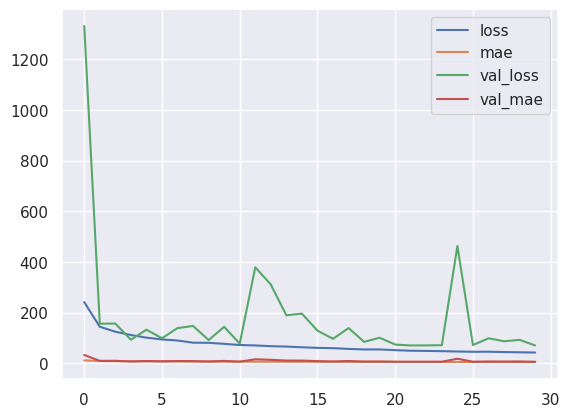

In [ ]:
pd.DataFrame(history.history).plot()

In [70]:
from tensorflow.keras.models import load_model
age_model = load_model('age_model.keras')

In [71]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 69.3690 - mae: 5.7749


In [72]:
y_pred = age_model.predict(X_test) 

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [73]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.791684679833175


In [74]:
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))

MSE: 70.10875582344597


In [75]:
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 8.373097146423536


In [76]:
print('R2 Score: {}'.format(r2_score(y_test, y_pred)))

R2 Score: 0.818605185695523


In [77]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [78]:
sozluk = {'Mean Absolute Error' : mae,
          'Mean Squared Error' : mse,
          'Root Mean Squared Error' : rmse, 
          'R2 Score' : r2}

sozluk

{'Mean Absolute Error': 5.791684679833175,
 'Mean Squared Error': 70.10875582344597,
 'Root Mean Squared Error': 8.373097146423536,
 'R2 Score': 0.818605185695523}

In [79]:
df2 = pd.DataFrame(sozluk, index = ['Age Model Metrics'])
df2

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 Score
Age Model Metrics,5.791685,70.108756,8.373097,0.818605


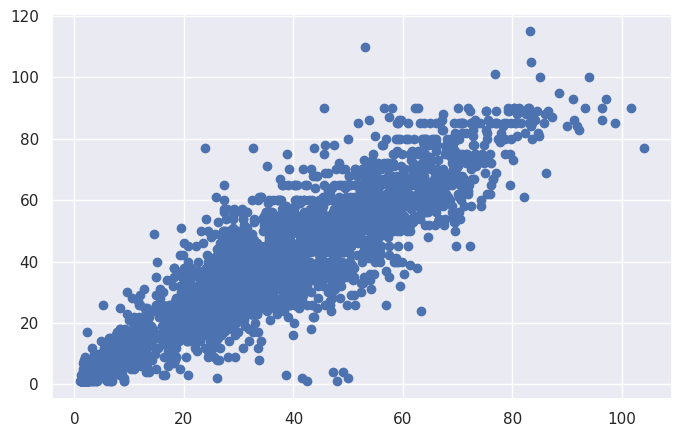

In [80]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_test);

# Cinsiyet Tahmini Modeli
Model, cinsiyeti tahmin etmek için ikili sınıflandırma yapar. 


In [81]:
y = df['gender'].values

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [82]:
gender_model = Sequential()

# Katman 1
# Görüntüde temel kenar ve köşe gibi düşük seviyeli özellikleri algılar.
gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

# Katman 2
# Daha karmaşık özellikleri öğrenir.
gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

# Katman 3
# Daha derin özellikleri öğrenir ve model kapasitesini artırır.
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

# Flatten Katmanı
gender_model.add(Flatten())

# Fully Connected (Dense) Katman 1
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

# Fully Connected (Dense) Katman 2 (Çıkış Katmanı)
gender_model.add(Dense(1, activation='sigmoid')) # Çıkışı 0 ile 1 arasında normalize eder, ikili sınıflandırma için uygundur.

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
# Binary_crossentropy = İkili sınıflandırma için uygun kayıp fonksiyonu.
# Accuracy = Eğitim ve değerlendirme sırasında kullanılan doğruluk oranı metrik olarak seçilmiştir.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Callbacks

- Callback'ler, eğitim sürecini daha etkili ve kontrollü bir şekilde yönetmek için kullanılan araçlardır. Aşağıda tanımlanan callback'ler, modelin eğitim sürecini iyileştirmek ve erken durdurma gibi özellikler sağlamak için kullanılmıştır.

In [83]:
# Modelin en iyi performans gösterdiği noktada ağırlıkları kaydetmek.
checkpoint = ModelCheckpoint('gender_model.keras', monitor='val_loss', save_best_only=True, mode='min')

#Eğitim sırasında doğrulama seti doğruluğu (val_accuracy) iyileşmediğinde erken durdurma yapmak.
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1), checkpoint]

# Avantajı: Eğitim sırasında zaman kaybını önler ve aşırı öğrenmenin önüne geçer.

In [84]:
history = gender_model.fit(X_train, y_train, 
                           epochs=15,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6912 - loss: 0.6148 - val_accuracy: 0.5206 - val_loss: 0.8519 - learning_rate: 0.0010
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8330 - loss: 0.3635 - val_accuracy: 0.7513 - val_loss: 0.4681 - learning_rate: 0.0010
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8638 - loss: 0.3068 - val_accuracy: 0.8684 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8741 - loss: 0.2895 - val_accuracy: 0.8806 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8827 - loss: 0.2692 - val_accuracy: 0.8705 - val_loss: 0.2949 - learning_rate: 0.0010
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8821 - loss: 0.2747 - val_accuracy: 0.8817 - val_loss: 0.2658 - learning_rate: 0.0010
Epoch 7/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8944 - loss: 0

In [85]:
gender_model = load_model('gender_model.keras')

In [86]:
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1])) 

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9124 - loss: 0.2093
Accuracy for test set: 0.9078253507614136


In [87]:
y_pred = gender_model.predict(X_test)
y_pred = [0 if i <0.5 else 1 for i in y_pred ] 

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2468
           1       0.91      0.90      0.90      2273

    accuracy                           0.91      4741
   macro avg       0.91      0.91      0.91      4741
weighted avg       0.91      0.91      0.91      4741



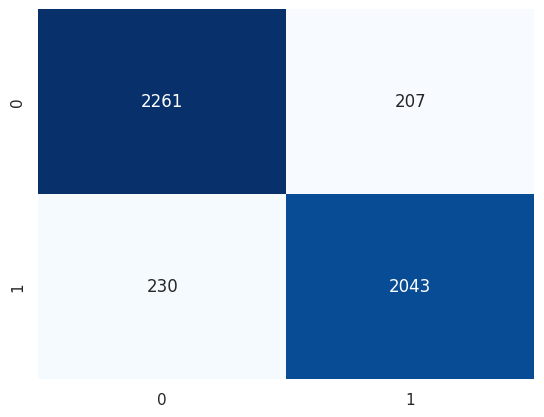

In [89]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt='d'); 

# Karmaşıklık Matrisi (Confusion Matrix)

Bir confusion matrix, genellikle şu bileşenleri içerir:

1. Sütunlar ve Satırlar:
- Satırlar (Gerçek Etiketler):
- - Satır 0: Gerçek sınıf 0 (örneğin, "Erkek").
- - Satır 1: Gerçek sınıf 1 (örneğin, "Kadın").
- Sütunlar (Tahmin Edilen Etiketler):
- - Sütun 0: Tahmin edilen sınıf 0.
- - Sütun 1: Tahmin edilen sınıf 1.
    
2. Değerler:
Her hücre, belirli bir sınıfın doğru veya yanlış tahmin edildiği örnek sayısını içerir.

- Hücre (0, 0): Gerçek sınıf 0 ve tahmin edilen sınıf 0 olan doğru tahminlerin sayısı (True Negatives - TN).
- Hücre (1, 1): Gerçek sınıf 1 ve tahmin edilen sınıf 1 olan doğru tahminlerin sayısı (True Positives - TP).
- Hücre (0, 1): Gerçek sınıf 0, ancak tahmin edilen sınıf 1 olan yanlış pozitiflerin sayısı (False Positives - FP).
- Hücre (1, 0): Gerçek sınıf 1, ancak tahmin edilen sınıf 0 olan yanlış negatiflerin sayısı (False Negatives - FN).

# Karmaşıklık Matrisin Analizi:
1. Doğru Tahminler:

- True Negatives (TN): 2261
- - Model, gerçek sınıfı 0 olan 2261 örneği doğru şekilde 0 olarak tahmin etmiş.
- True Positives (TP): 2043
- - Model, gerçek sınıfı 1 olan 2043 örneği doğru şekilde 1 olarak tahmin etmiş.
  
2. Yanlış Tahminler:

- False Positives (FP): 207
- - Model, gerçek sınıfı 0 olan 207 örneği yanlış bir şekilde 1 olarak tahmin etmiş.
- False Negatives (FN): 230
- - Model, gerçek sınıfı 1 olan 230 örneği yanlış bir şekilde 0 olarak tahmin etmiş.


# Performans Metrikleri
1. Accuracy (Doğruluk):
   
    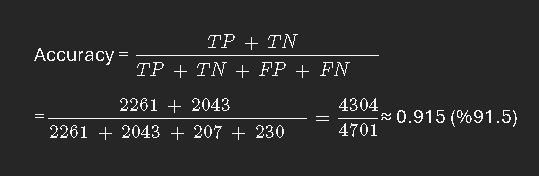
   
2. Precision (Kesinlik):
 
    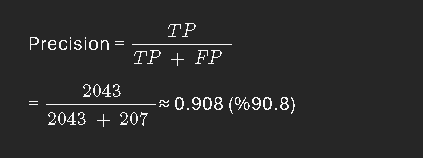

3. Recall (Duyarlılık / TPR):

   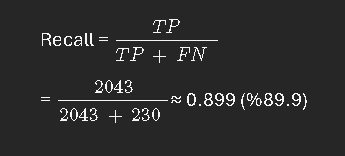

4. F1-Skoru, Precision ve Recall'un harmonic ortlamasıdır:

   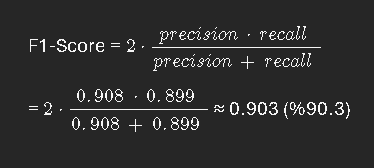

Gender model 1 AUC score: 0.9074692803476224


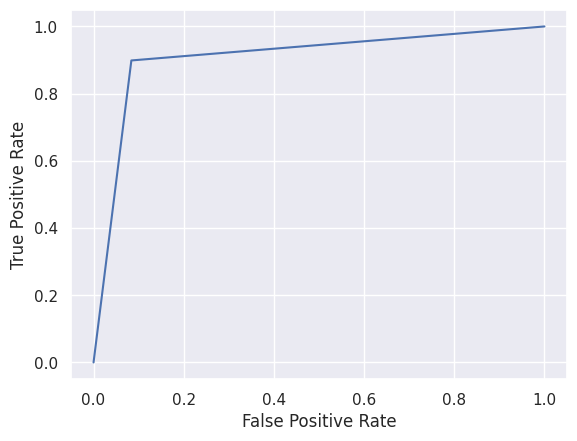

In [90]:
plot_roc_curve(y_test, y_pred)
print(f'Gender model 1 AUC score: {roc_auc_score(y_test, y_pred)}')

# AUC (Area Under the Curve) ve ROC (Receiver Operating Characteristic)
AUC score, modelin cinsiyet sınıflandırmasındaki ayrım yapma yeteneğini ölçen AUC (Area Under the Curve) değerini belirtir. Bu değer, ROC (Receiver Operating Characteristic) eğrisi altındaki alanı ifade eder.

AUC değeri, modelin pozitif ve negatif sınıflar arasında ne kadar iyi ayrım yapabildiğini gösterir. Aşağıdaki aralıklarla değerlendirilir:

- 0.5: Model rastgele tahmin yapıyor, sınıflar arasında ayrım yapma yeteneği yok.
- 0.6 - 0.7: Kötü ayrım yapma yeteneği.
- 0.7 - 0.8: Kabul edilebilir seviyede ayrım yapma yeteneği.
- 0.8 - 0.9: İyi bir model performansı.
- 0.9 ve üzeri: Mükemmel ayrım yapma yeteneği.

Bu değerin 0.9 üzerinde olması, modelinizin cinsiyet tahmini için çok iyi bir ayrım yapma yeteneğine sahip olduğunu gösterir. Model, erkek ve kadın sınıfları arasında yüksek doğruluk oranıyla ayrım yapabilmektedir.

# Etnik Köken Tahmini Modeli
Model, etnik kökeni tahmin etmek için çok sınıflı sınıflandırma yapma.


In [91]:
y = df['ethnicity'].values
y = to_categorical(y, num_classes=5)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [93]:
ethnicity_model = Sequential()

ethnicity_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(Dropout(0.4))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(Dropout(0.5))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Flatten())

ethnicity_model.add(Dense(64, activation='relu'))
ethnicity_model.add(Dropout(0.4))

# Etnik köken sınıflarından birine ait olasılıkları tahmin eder.
ethnicity_model.add(Dense(5, activation='softmax')) # Çoklu sınıflandırma için Softmax
# softmax (Sınıflar arasında olasılık dağılımı oluşturur)

ethnicity_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# categorical_crossentropy – Çok sınıflı sınıflandırma için standart bir kayıp fonksiyonu.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [94]:
# Modelin en iyi performans gösterdiği noktada ağırlıkları kaydetmek.
checkpoint = ModelCheckpoint('ethnicity_model.keras', monitor='val_loss', save_best_only=True, mode='min')

#Eğitim sırasında doğrulama seti doğruluğu (val_accuracy) iyileşmediğinde erken durdurma yapmak.
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1), checkpoint]

# Avantajı: Eğitim sırasında zaman kaybını önler ve aşırı öğrenmenin önüne geçer.

In [95]:
history = ethnicity_model.fit(X_train, y_train, 
                           epochs=15,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.4435 - loss: 1.4920 - val_accuracy: 0.4318 - val_loss: 2.9381 - learning_rate: 0.0010
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6602 - loss: 0.9468 - val_accuracy: 0.6743 - val_loss: 0.8705 - learning_rate: 0.0010
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6904 - loss: 0.8613 - val_accuracy: 0.7152 - val_loss: 0.8003 - learning_rate: 0.0010
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7163 - loss: 0.8055 - val_accuracy: 0.7108 - val_loss: 0.8039 - learning_rate: 0.0010
Epoch 5/15
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7367 - loss: 0.7661
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7367 - loss: 0.7661 - val_accuracy: 0.6832 - val_loss: 0.8114 - learning_rate: 0.0010
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7570 - loss: 0

In [96]:
ethnicity_model = load_model('ethnicity_model.keras')

In [97]:
valid_score = ethnicity_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1])) 

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7965 - loss: 0.5653
Accuracy for test set: 0.803838849067688


In [98]:
y_pred =ethnicity_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2047
           1       0.84      0.86      0.85       904
           2       0.86      0.85      0.85       657
           3       0.70      0.76      0.73       804
           4       0.59      0.10      0.17       329

    accuracy                           0.80      4741
   macro avg       0.76      0.69      0.69      4741
weighted avg       0.79      0.80      0.78      4741



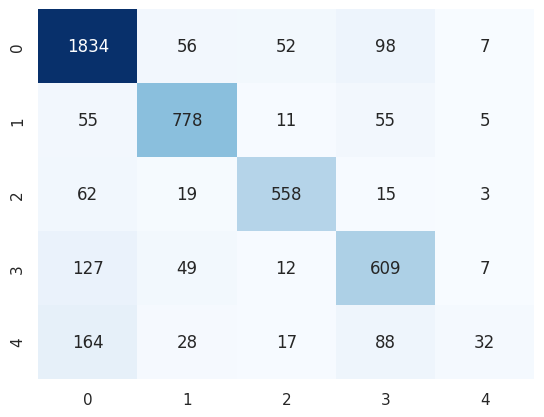

In [100]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt='d'); 

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


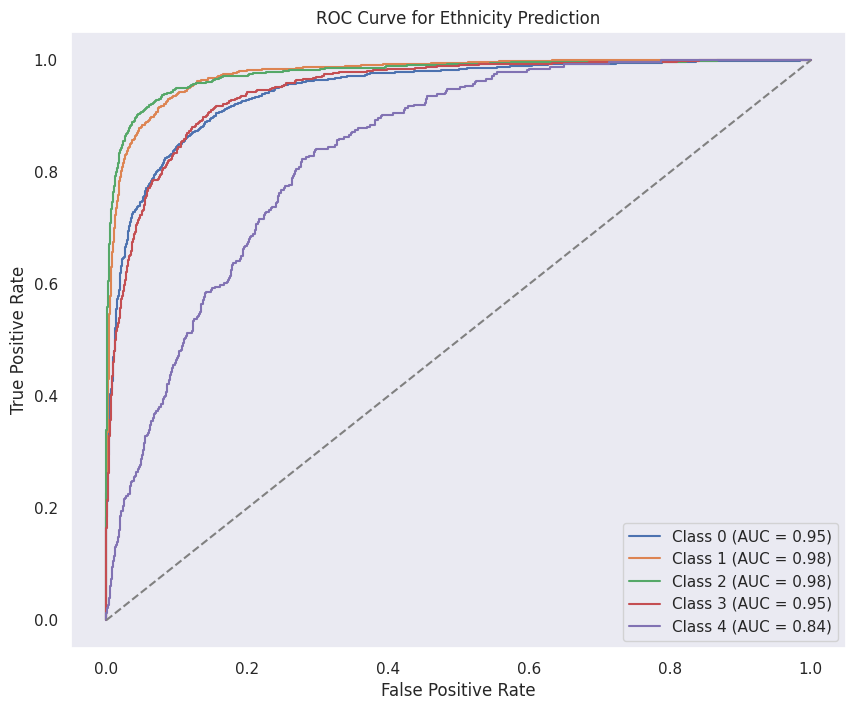

In [101]:
y_pred_prob = ethnicity_model.predict(X_test)  
y_true = y_test  
n_classes = y_pred_prob.shape[1]  

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    y_true_binary = (y_true == i).astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.title('ROC Curve for Ethnicity Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# AUC Değerleri:
AUC, ROC eğrisi altındaki alanı ifade eder ve modelin genel performansını özetler.

- Class 0 (AUC = 0.95): Bu sınıf için modelin çok iyi performans gösterdiği anlamına gelir.
- Class 1 (AUC = 0.98): Model, bu sınıfta mükemmele yakın ayrım yapabiliyor.
- Class 2 (AUC = 0.98): Model bu sınıfta da çok yüksek performans gösteriyor.
- Class 3 (AUC = 0.95): Modelin bu sınıfta güçlü bir performansa sahip olduğu gösteriliyor.
- Class 4 (AUC = 0.84): Bu sınıf için model performansı diğer sınıflara kıyasla daha düşük.


# Test Verisi ile Model Performansını Test Etme
Bu hücrede, eğitimli modelleri kullanarak test verisinden rastgele bir görüntü seçip yaş, cinsiyet ve etnik köken tahmini yapılacaktır.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━

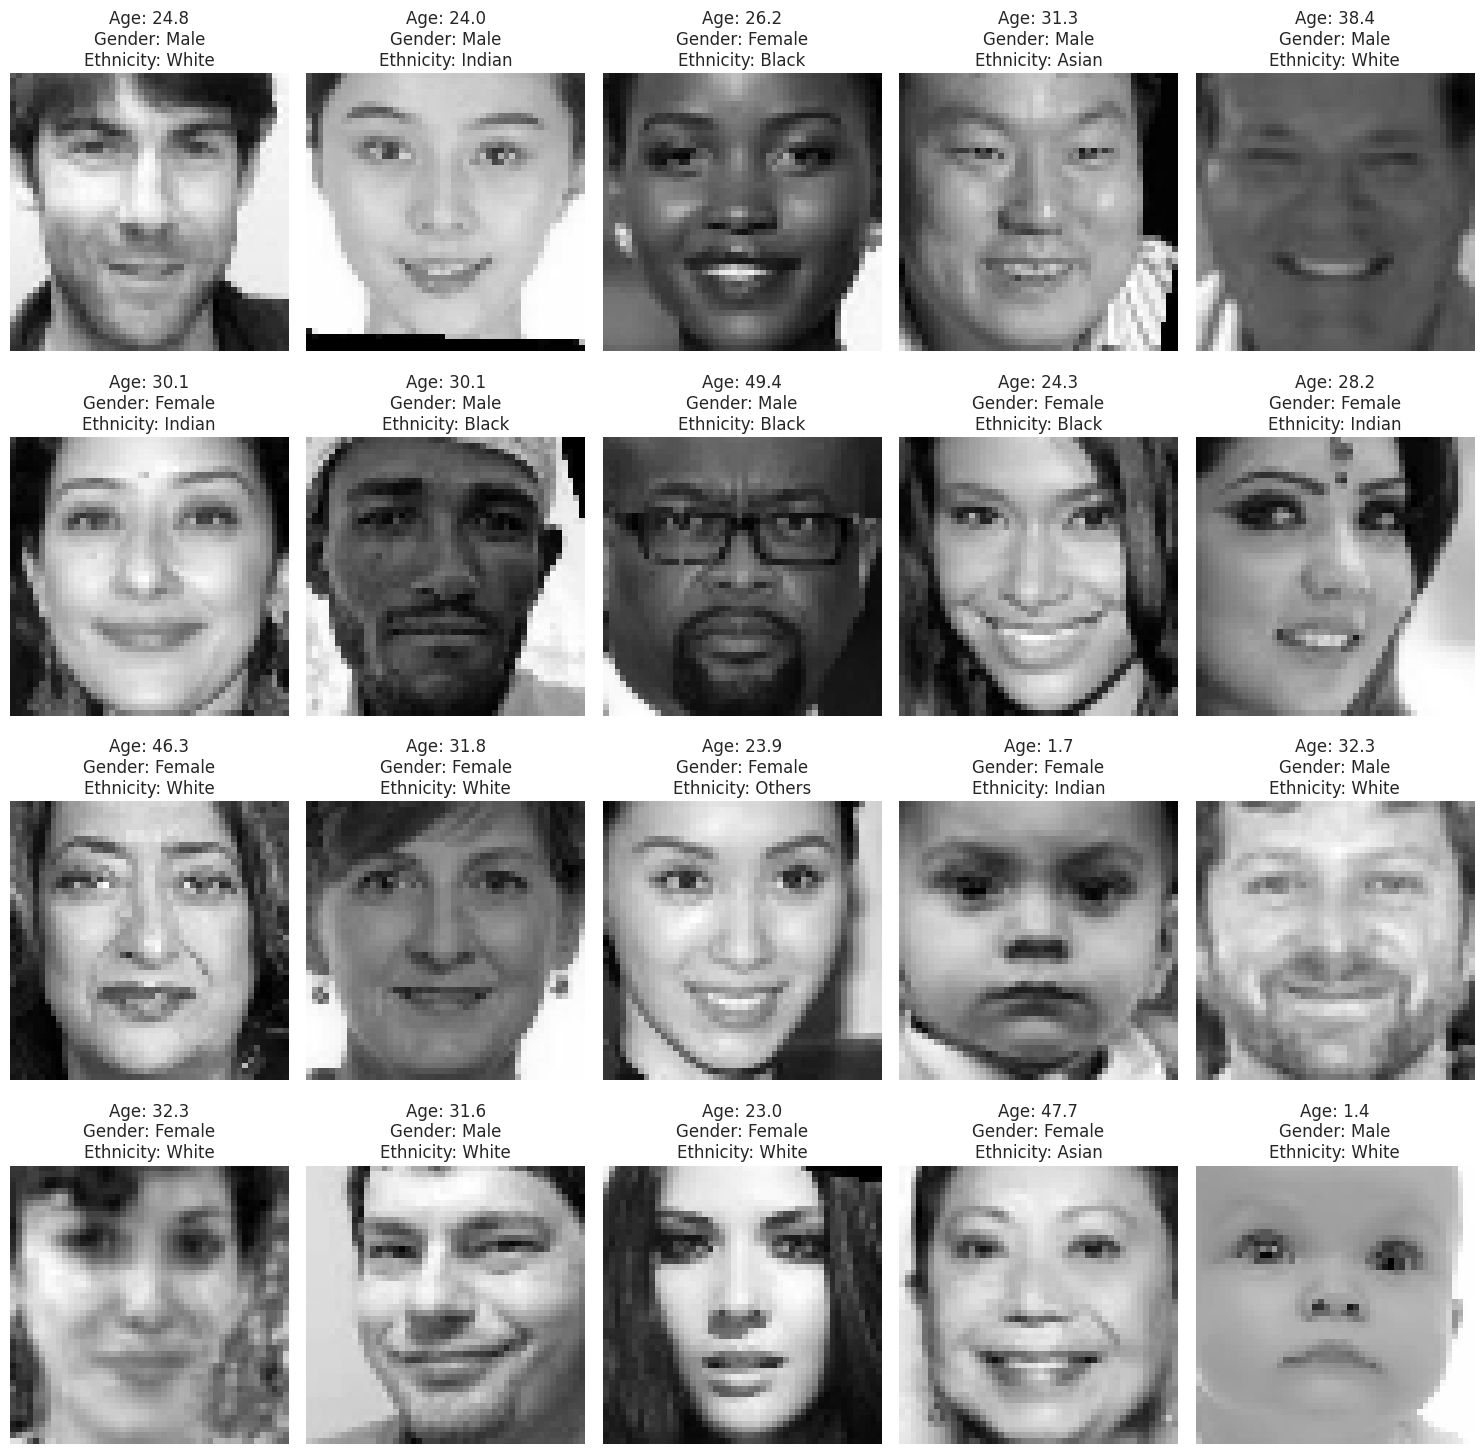

In [102]:
import random
import matplotlib.pyplot as plt

ethnicity_labels = ['White', 'Black', 'Asian', 'Indian', 'Others']

random_indices = random.sample(range(X_test.shape[0]), 20)
random_images = X_test[random_indices]
random_labels = y_test[random_indices]  

plt.figure(figsize=(15, 15))
for i, test_image in enumerate(random_images):
    test_image_expanded = np.expand_dims(test_image, axis=0)  

    age_pred = age_model.predict(test_image_expanded)
    age_pred = age_pred[0][0]  
    
    gender_pred = gender_model.predict(test_image_expanded)
    gender_pred = 'Male' if gender_pred[0][0] < 0.5 else 'Female'

    ethnicity_pred = ethnicity_model.predict(test_image_expanded)
    ethnicity_pred = ethnicity_labels[np.argmax(ethnicity_pred[0])]  

    plt.subplot(4, 5, i + 1)  
    plt.imshow(test_image.reshape(48, 48), cmap='gray')
    plt.title(f"Age: {age_pred:.1f}\nGender: {gender_pred}\nEthnicity: {ethnicity_pred}")
    plt.axis('off')

plt.tight_layout()
plt.show()